fetch sum_hex and genbank meta
done

In [1]:
import pickle as pkl

In [2]:
def fetch_seq(f:str)->str:
    gb:dict=pkl.load(open(f,'rb'))
    seq:str=gb['GBSet']['GBSeq']['GBSeq_sequence']
    return seq

In [3]:
print(fetch_seq('genbank_meta/AbV2||KY357507.pkl'),file=open('AbV2||KY357507.fasta','a'))

In [3]:
genome_seq=fetch_seq('genbank_meta/AbV2||KY357507.pkl')

In [4]:
hexd=pkl.load(open('sum_hex.pkl','rb'))


In [5]:
from typing import List,Tuple
ilist:List[str]=hexd['AbV2||KY357507']

In [42]:
transannot=['0s','0a','1s','1a','2s','2a']
transannot_indice={j:i for i,j in enumerate(transannot)}
from typing import Tuple,Dict,Union
routine_dict=Dict[str,Union[str,int,float]]
def get_genome_length(translist:List[str])->int:
    return len(translist[0])

def get_valid_seg(translist:List[str],name:str='xx',thresh:int=100)->List[Tuple[routine_dict,str]]:
    output=[]
    for i,annot in zip(translist,transannot):
        b=e=0
        for seg in i.split('*'):
            e=b+len(seg)
            if len(seg)>thresh:
                head={'name':name,
                      'transannot':annot,
                      'prob':b,
                      'proe':e}
                output.append((head,seg))
            b=e+1
    return output


def scanindice_to_proindice(prob:int,scanb:int,scane:int):
    # TODO
    delta=0 
    return prob+delta+scanb,prob+delta+scane

def seg_to_fasta(seg:List[Tuple[routine_dict,str]])->str:
    o=[]
    for s in seg:
       head='> ' + ','.join([f'{k}={v}' for k,v in s[0].items()])
       o.extend([head,s[1]])
    return '\n'.join(o)
    

In [35]:
from typing import Tuple
def proindice_to_genindice(genome:str,prob:int,proe:int,transannot:str)->Tuple[int,int]:
    frame,direction=transannot
    frame=int(frame)
    b_,e_=frame+prob*3,frame+proe*3
    if direction=='s':
        return b_,e_
    else:
        return len(genome)-e_, len(genome)-b_

def genindice_to_proindice(genome:str,genb:int,gene:int,transannot:str)->Tuple[int,int]:
    frame,direction=transannot
    frame=int(frame)
    
    if direction=='s':
        b_,e_=(genb-frame)//3,(gene-frame)//3
        return b_,e_
    else:
        return (len(genome)-frame-gene)//3,(len(genome)-frame-genb)//3
        

def genome_annot_indice(genome:str,genb:int,gene:int,transannot:str)->Tuple[int,int]:
    'return: genseq segments '
    frame,direction=transannot
    # frame=int(frame)
    o=genome[genb:gene]
    o=o if direction=='s' else o[::-1]
    return o



In [8]:
from Bio.Seq import Seq
translate= lambda x:Seq(x).translate()._data.decode()
import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)
def hextranslate(genome:str)->List[str]:
    o=[]
    genome_r=genome[::-1]
    for i in [0,1,2]:
        o.append(translate(genome[i:]))
        o.append(translate(genome_r[i:]))
    return o

In [37]:
def test_seg():
    genome=fetch_seq('genbank_meta/AbV2||KY357507.pkl')
    t=hextranslate(genome)
    segs=get_valid_seg(t,thresh=100)
    for o,(head,seq) in enumerate(segs):
        prob,proe,annot=head['prob'],head['proe'],head['transannot']
        genb,gene=proindice_to_genindice(genome,prob,proe,annot)
        assert genindice_to_proindice(genome,genb,gene,annot)==(prob,proe),f'{o},{prob},{proe},{annot}'
        assert translate(genome_annot_indice(genome,genb,gene,annot))==seq,f'{o},{prob},{proe},{annot}'
    
test_seg()

In [68]:
from pathlib import Path
def gen_fasta():
    od=Path('genome_fasta')
    for meta in Path('genbank_meta/').iterdir():
        s=meta.stem
        genseq=fetch_seq(meta)
        print(f'> {s}\n{genseq}',file=open(str(od/(s+':genome.fasta')),'w'))
        segs=get_valid_seg(hextranslate(genseq),name=s,thresh=100)
        print(len(segs))
        print(seg_to_fasta(segs),file=open(str(od/(s+':segs.fasta')),'w'))
        break
    
def tmp_write_meta(meta:Path,od=Path('genome_fasta/')):
    s=meta.stem
    try:
        genseq=fetch_seq(meta)
        print(f'> {s}\n{genseq}',file=open(str(od/(s+':genome.fasta')),'w'))
        segs=get_valid_seg(hextranslate(genseq),name=s,thresh=100)
        # print(len(segs))
        print(seg_to_fasta(segs),file=open(str(od/(s+':segs.fasta')),'w'))
    except:
        print(s)
# gen_fasta()
# tmp_write_meta(Path('genbank_meta/AaCV1|dsRNA2|LC350278.pkl'))

In [69]:
from multiprocessing import Pool
pool=Pool(processes=8)
pool.map(tmp_write_meta,Path('genbank_meta/').iterdir())
print('ok')

ok


In [60]:
od=Path('genome_fasta')
for meta in Path('genbank_meta/').iterdir():
    s=meta.stem
    genseq=fetch_seq(meta)
    print(f'> {s}\n{genseq}',file=open(str(od/(s+':genome.fasta')),'w'))
    segs=get_valid_seg(hextranslate(genseq),name=s,thresh=100)
    print(len(segs))
    print(seg_to_fasta(segs),file=open(str(od/(s+':segs.fasta')),'w'))
    break

1


In [45]:
genome=fetch_seq('genbank_meta/AbV2||KY357507.pkl')
t=hextranslate(genome)
segs=get_valid_seg(t,thresh=150,name='AbV2||KY357507')
segs

[({'name': 'AbV2||KY357507', 'transannot': '0s', 'prob': 637, 'proe': 4363},
  'ITRIQNLQNYLKGLASGKAKNVDFEALERRVGNSVIYFSTPVVEVGVTLANLKNVISLNEYIVASDDACYHGNPFGRFKKASCGCVKGKDDTFMKILPANWASVVQRAGRVSRTSDGTVIVCGEPEGKRFFRYSPSARGLIEEEIRSLSPMLAQLDCDDGPIHPREEVPIATPSRALVHIPGLGRQTRGHVCKGFQWRVRFLNMKAALERKLDSDDVLVSVAWDEVPIDEEGRVEELEPIGREHGPKDLSPTDITPGFIDDETAEESKPLESTDSLTSIESEEENRGALSRDEDVILNPRRDGTGARVSQAMHKAYCSCDPIYHIFGRMCRSRHSWPGEWIATQMTKSVSAINKTLREMRKGNPLSMRQLKKGEGITNDKCQRSWYDPREKPALASIAATETLGDDWYQPRPRDDSESEVIVTRPVVRELKQAVKDMAQLCKKWATGNKSYFYSVFKSGSLRLDGVKGKGCDMPMAVFWNVALGLLQGETKVLERTMFPKFGSNHRPCGVRSWYEFPVDQELRLYAKAIVYLIERMDDDFLWDAGMIEEDGDDLPEYDPDAILSWFEICEEIFMQLFLENAPLESVIAREDQRRWQSFVGAQFHTRDRKSGRVALTTMVEVNIEKIKSMSGFCYLSFFKRTDRELAKLAVKLGIWPRAEAVIREMPETMLQVDSRKRFTHAVETPVVRLPRNAQRVGGSLKPQGTAVKTFKGTKMEWRAEWSHRLQSLGIPEHVWNKHGIWVQLDCCGQEITEQDLVLAENDEVYIVYNKKSKFNNLNWISKKHSISQPPLPFLQTRGYPLNATLPYHAHGAVICRPLDNKPLGLVSFPNQVLNFNESLYLTLAAKNRRAAHLSSKTQPKDIRCKYCRSWGWPSEDVGVCESCAGLKKFPMSIQRNERALAAYRLIQTQLNKIRTLDNYF

In [47]:
print(seg_to_fasta(segs),file=open('AbV2||KY357507:segs.fasta','a'))

In [12]:
import matplotlib.pyplot as plt
lenlist=[]
for i in ilist:
    lenlist.extend([len(seg) for seg in i.split('*')])

(array([493., 322., 150., 100.,  54.,  40.,  23.,  12.,   8.,   7.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

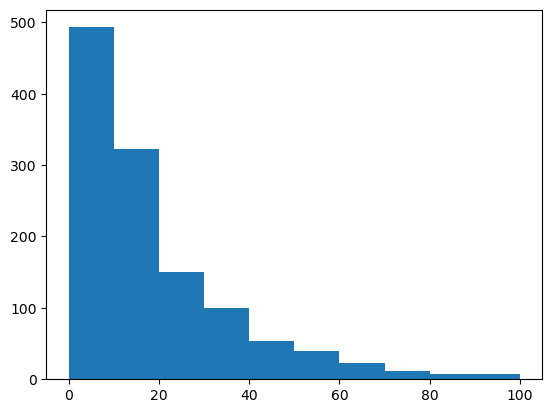

In [16]:
plt.hist(lenlist,range=[0,100])

In [18]:
lenlist.sort()


In [21]:
lenlist[-10:]

[106, 106, 111, 111, 117, 121, 159, 172, 216, 3726]

In [ ]:
from typing import List
def hex_fasta(ilist:List[str])->str:
    return